# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [3]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [4]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
29897
Now saving the 200th result...
64942
Now saving the 300th result...
93722
Now saving the 400th result...
122685
Now saving the 500th result...
149843
Now saving the 600th result...
179392
Now saving the 700th result...
206856
Now saving the 800th result...
236606
Now saving the 900th result...
261322
Now saving the 1000th result...
292311
Now saving the 1100th result...
326286


#  

#### Reduce columns:

In [5]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

355314


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,Subdirectory,filename,station_code,station_number,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,1443.396226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,191.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.504032,405.660377,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,...,24,218.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.500000,1537.735849,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,24,33.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.650538,1490.566038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,83.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24,1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
84264,R014207819,4793-15,201.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 700,width: 3497"
75828,R014207818,4257-15,245.png,num2,1.500000,1275.000000,NaN,NaN,NaN,NaN,...,15.0,67.0,162.0,12.0,33,38,NaN,NaN,NaN,NaN
135102,R014207828,4390-50-2,200.png,loss,1.592742,1022.448980,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
225097,R014207838,4537-72,177.png,num,1.500000,1434.693878,NaN,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148409,R014207829,4310-19-2,226.png,loss,1.536290,1258.536585,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
335373,R014207969,1278-13B,45.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 758,width: 7333"
1826,R014207711,53,77.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 641,width: 2698"
107816,R014207825,3753-19A,13.png,loss,1.854839,1402.083333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
108236,R014207825,3754-38A,27.png,num,1.645161,1402.083333,NaN,2.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223994,R014207838,4529-43,150.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 702,width: 2853"


#  

#### Split results into different metadata types (dot, num, num2):

In [7]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'dot', 'num2'], dtype=object)

In [8]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

63511


In [9]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

94928


In [10]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

4179


In [11]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

33580


In [12]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

159116


In [13]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

355314

#### num2 - check timestamp components, construct timestamp:

In [14]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
215491,67,161.0,06,18,43
175605,67.0,242.0,7.0,53.0,27
229336,67.0,172.0,7.0,52,32.0
221138,65.0,177.0,10.0,00,10
185819,68.0,25.0,9.0,41.0,12
59708,67.0,165.0,18.0,10.0,54.0
217575,67,189,02,34,42
60357,67.0,214.0,11.0,35.0,5.0
176526,67.0,331,7.0,54.0,51.0
211561,61,081,18,14,06


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

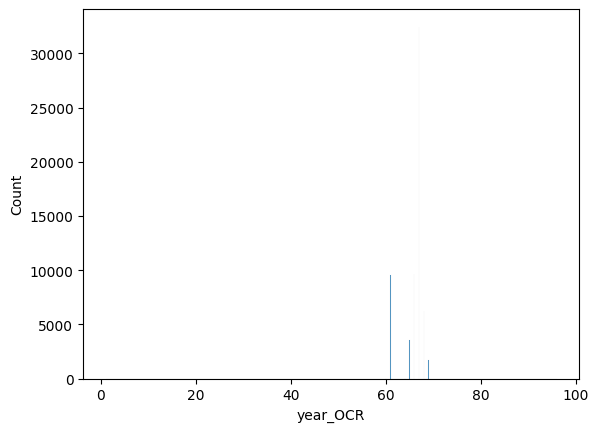

In [15]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [16]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [17]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
235745,1967.0,67.0
137212,1968.0,68.0
54238,1967.0,67.0
162342,1967.0,67.0
67908,NaN,NaN
192044,1965.0,65.0
241104,1966.0,66.0
58946,NaN,NaN
168099,1967.0,67.0
234786,NaN,NaN


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

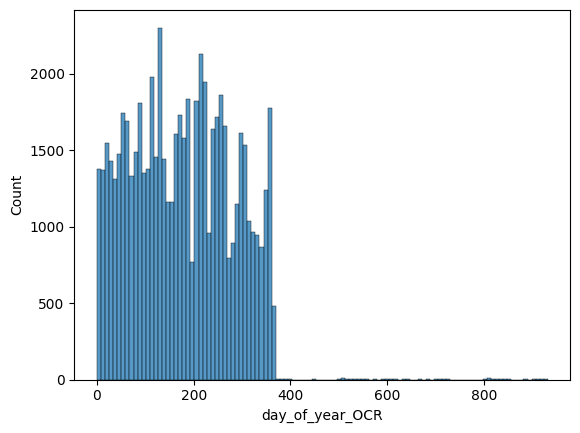

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [19]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
142824,173.0,173.0
220881,163.0,163.0
182578,89.0,89.0
238901,286.0,286.0
186304,68.0,68.0
180874,301.0,301.0
56742,3.0,3.0
72173,301.0,301.0
211918,88.0,88.0
165623,74.0,74.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

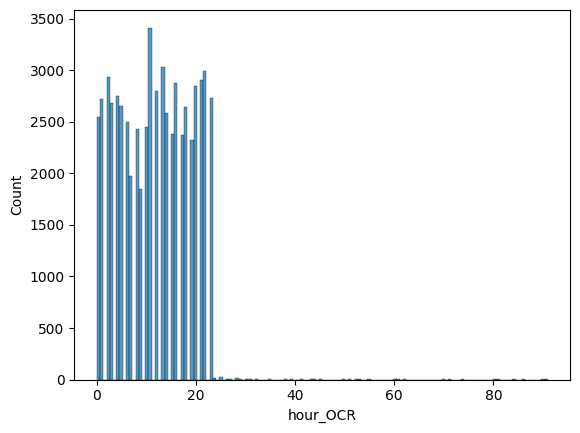

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [21]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
233225,1.0,1.0
218213,12.0,12.0
63183,20.0,20.0
222815,12.0,12.0
54010,23.0,23.0
225766,16.0,16.0
227470,20.0,20.0
69791,20.0,20.0
195860,2.0,2.0
169234,17.0,17.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

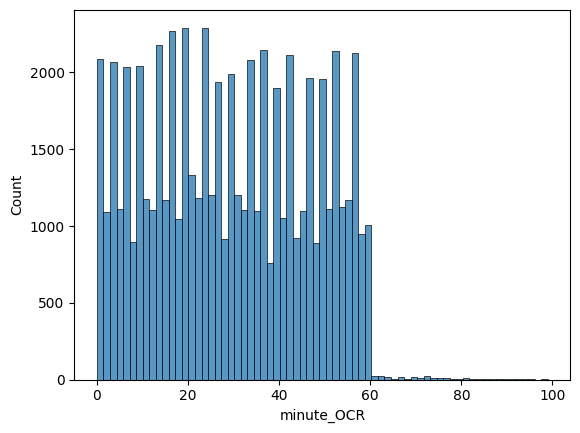

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [23]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
177550,31.0,31.0
143544,15.0,15.0
231818,27.0,27.0
169004,39.0,39.0
195511,33.0,33.0
237135,37.0,37.0
179423,15.0,15.0
206725,4.0,4.0
210807,0.0,0.0
76099,43.0,43.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

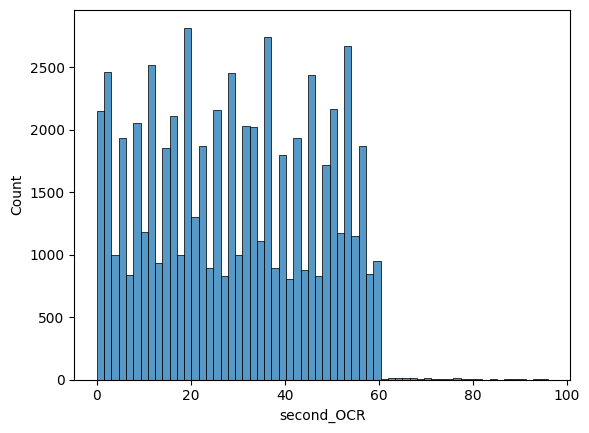

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [25]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
71010,8.0,8.0
180061,46.0,46.0
161842,4.0,4.0
180202,56.0,56.0
162178,46.0,46.0
180221,36.0,36.0
172603,52.0,52.0
142959,37.0,37.0
192635,12.0,12.0
53928,36.0,36.0


construct timestamp:

In [26]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

63511


In [27]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
210016,1967.0,02,27,19.0,44.0,17.0,1967-02-27 19:44:17,1
56933,NaN,04,08,3.0,9.0,25.0,NaT,0
191430,1965.0,08,12,4.0,4.0,10.0,1965-08-12 04:04:10,1
195191,1966.0,12,20,21.0,10.0,9.0,1966-12-20 21:10:09,1
59744,1967.0,06,16,11.0,36.0,46.0,1967-06-16 11:36:46,1
54224,1967.0,01,25,20.0,27.0,29.0,1967-01-25 20:27:29,1
125918,1966.0,11,04,13.0,46.0,19.0,1966-11-04 13:46:19,1
228267,1968.0,05,17,15.0,7.0,31.0,1968-05-17 15:07:31,1
215674,1967.0,06,11,13.0,58.0,17.0,1967-06-11 13:58:17,1
192074,1965.0,11,20,3.0,57.0,7.0,1965-11-20 03:57:07,1


#  

#### num - check timestamp components, construct timestamp:

In [28]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
318240,3.0,2.0,9.0,1.0,1.0,2.0,2.0,3.0,0.0,9.0
102565,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,4.0
89814,1.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0
161649,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
334094,4.0,0.0,8.0,2.0,1.0,8.0,1.0,8.0,5.0,5.0
265622,4.0,1.0,8.0,1.0,1.0,8.0,3.0,9.0,2.0,0.0
328370,4.0,0.0,8.0,5.0,0.0,0.0,5.0,9.0,3.0,9.0
285491,5.0,1.0,9.0,5.0,1.0,5.0,4.0,6.0,4.0,5.0
91100,1.0,2.0,1.0,3.0,2.0,2.0,5.0,0.0,2.0,2.0
327335,4.0,0.0,5.0,1.0,2.0,1.0,5.0,6.0,5.0,9.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

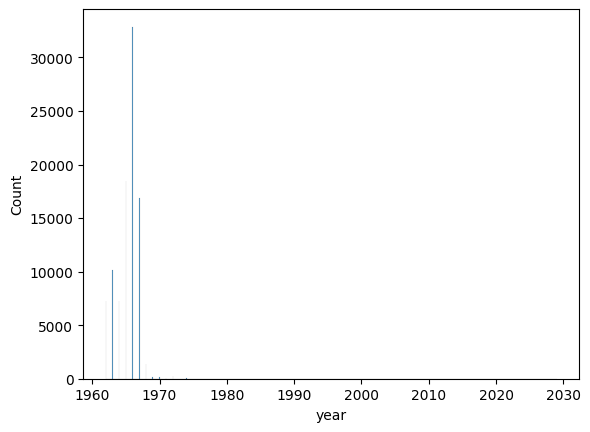

In [29]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [30]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
288003,1966.0,4.0
275223,1966.0,4.0
334435,1965.0,3.0
279601,1967.0,5.0
339527,1965.0,3.0
257628,1966.0,4.0
290168,1966.0,4.0
90978,1963.0,1.0
329133,1966.0,4.0
309552,1965.0,3.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

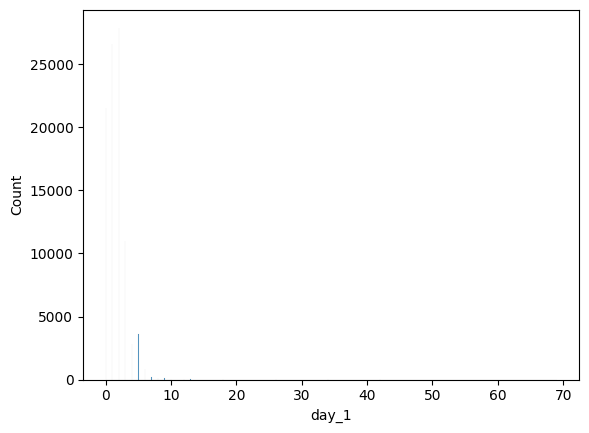

In [31]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [32]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

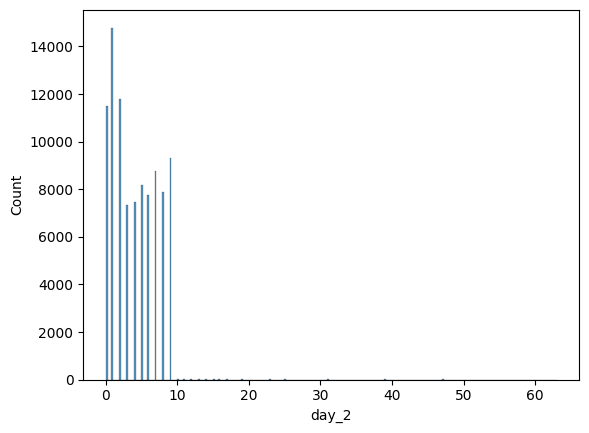

In [33]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [34]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

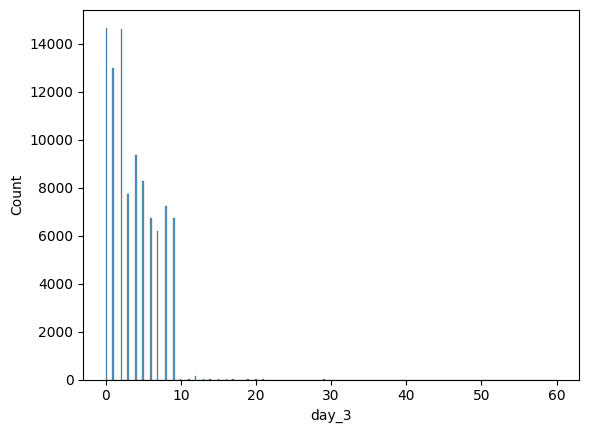

In [35]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [36]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [37]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

94928


,day_of_year,day_1,day_2,day_3
335934,243.0,2.0,4.0,3.0
304891,178.0,1.0,7.0,8.0
342254,181.0,1.0,8.0,1.0
91273,32.0,0.0,3.0,2.0
336437,295.0,2.0,9.0,5.0
108141,111.0,1.0,1.0,1.0
304611,194.0,1.0,9.0,4.0
122708,NaN,4.0,0.0,4.0
85593,111.0,1.0,1.0,1.0
319104,214.0,2.0,1.0,4.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

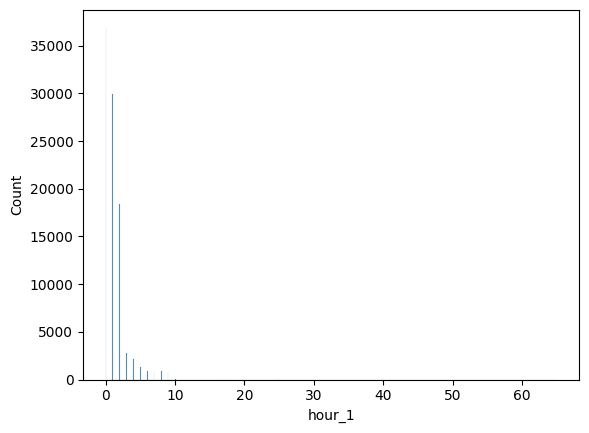

In [38]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [39]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

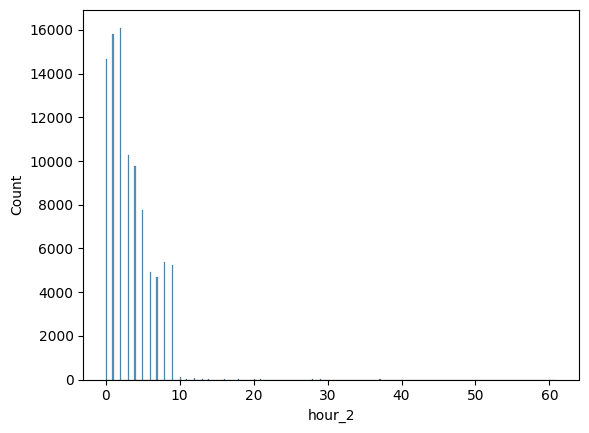

In [40]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [41]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [42]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

94928


,hour,hour_1,hour_2
270985,2.0,0.0,2.0
280742,3.0,0.0,3.0
342150,9.0,0.0,9.0
283345,3.0,0.0,3.0
277586,20.0,2.0,0.0
223513,12.0,1.0,2.0
267760,3.0,0.0,3.0
263247,2.0,0.0,2.0
280976,12.0,1.0,2.0
278684,4.0,0.0,4.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

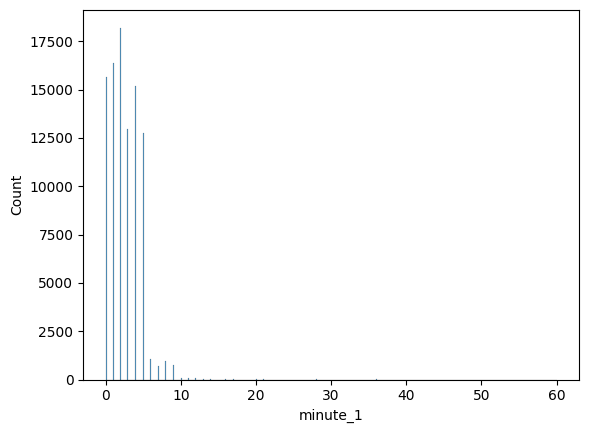

In [43]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [44]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

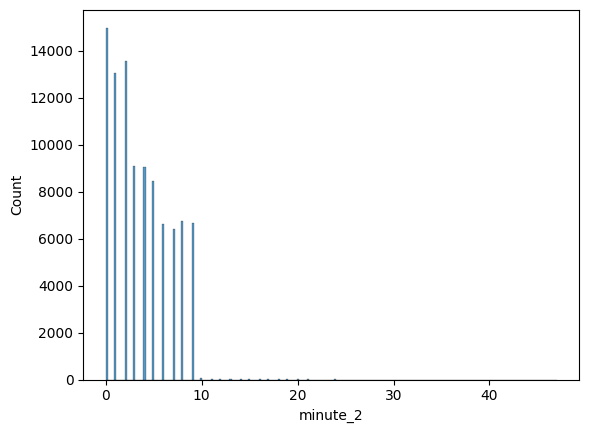

In [45]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [46]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [47]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

94928


,minute,minute_1,minute_2
309430,44.0,4.0,4.0
328204,31.0,3.0,1.0
332941,51.0,5.0,1.0
321235,23.0,2.0,3.0
264344,56.0,5.0,6.0
122797,23.0,2.0,3.0
258887,41.0,4.0,1.0
222218,21.0,2.0,1.0
174284,11.0,1.0,1.0
318406,34.0,3.0,4.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

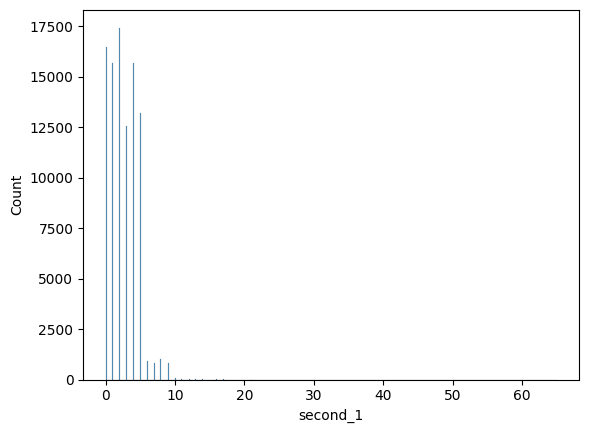

In [48]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [49]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

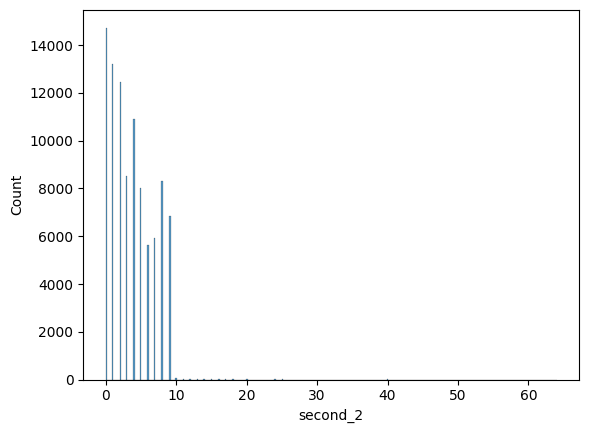

In [50]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [51]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [52]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

94928


,second,second_1,second_2
281061,25.0,2.0,5.0
284372,NaN,0.0,NaN
328846,35.0,3.0,5.0
306653,50.0,5.0,0.0
340502,44.0,4.0,4.0
329371,29.0,2.0,9.0
119575,43.0,4.0,3.0
278363,40.0,4.0,0.0
300813,25.0,2.0,5.0
296935,30.0,3.0,0.0


construct timestamp:

In [53]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

94928


In [54]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
276130,1966.0,10,12,15.0,59.0,17.0,1966-10-12 15:59:17,1
322985,1966.0,01,31,6.0,5.0,7.0,1966-01-31 06:05:07,1
301969,1967.0,06,06,9.0,26.0,28.0,1967-06-06 09:26:28,1
259767,1966.0,06,29,5.0,26.0,27.0,1966-06-29 05:26:27,1
301939,1967.0,05,31,10.0,53.0,53.0,1967-05-31 10:53:53,1
273394,1964.0,NaN,NaN,10.0,NaN,21.0,NaT,0
296003,1966.0,10,25,0.0,25.0,2.0,1966-10-25 00:25:02,1
344832,1964.0,04,20,21.0,2.0,11.0,1964-04-20 21:02:11,1
158229,1963.0,08,08,21.0,11.0,11.0,1963-08-08 21:11:11,1
263928,1966.0,06,17,19.0,18.0,22.0,1966-06-17 19:18:22,1


#  

#### dot - check timestamp components, construct timestamp:

In [55]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
315743,NaN,1.0,8.0,8.0,8.0,8.0,24.0,8.0,9.0,8.0,NaN
308280,NaN,1.0,4.0,4.0,4.0,1.0,4.0,0.0,12.0,1.0,NaN
268588,NaN,2.0,8.0,2.0,2.0,10.0,8.0,2.0,16.0,0.0,NaN
315657,NaN,8.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,9.0,NaN
316425,NaN,1.0,8.0,0.0,9.0,1.0,16.0,8.0,8.0,1.0,NaN
309116,NaN,1.0,8.0,8.0,16.0,0.0,0.0,8.0,25.0,1.0,NaN
312591,NaN,1.0,16.0,8.0,8.0,0.0,8.0,1.0,25.0,9.0,NaN
310493,NaN,1.0,16.0,1.0,17.0,0.0,10.0,0.0,24.0,17.0,NaN
310482,NaN,1.0,8.0,1.0,9.0,0.0,9.0,1.0,8.0,9.0,NaN
312524,NaN,1.0,16.0,8.0,1.0,0.0,9.0,0.0,24.0,1.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

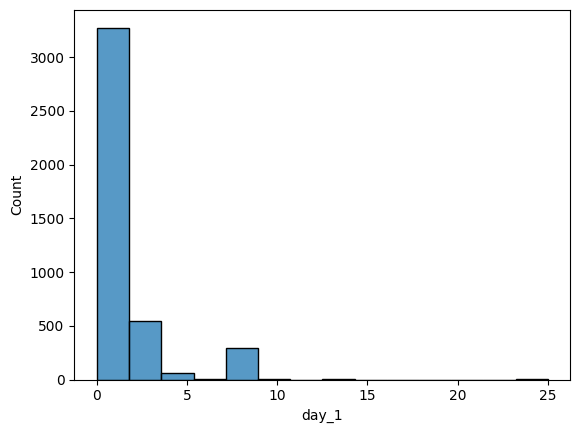

In [56]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [57]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

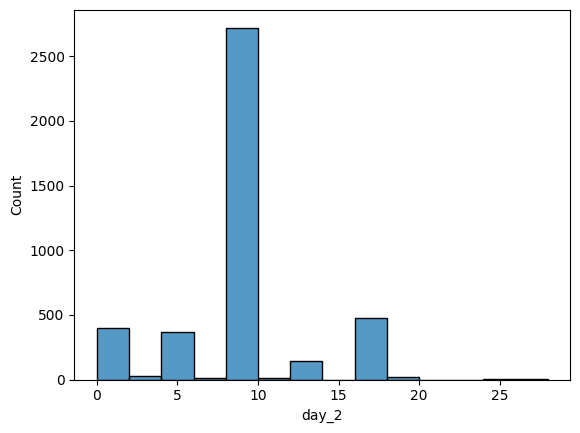

In [58]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [59]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

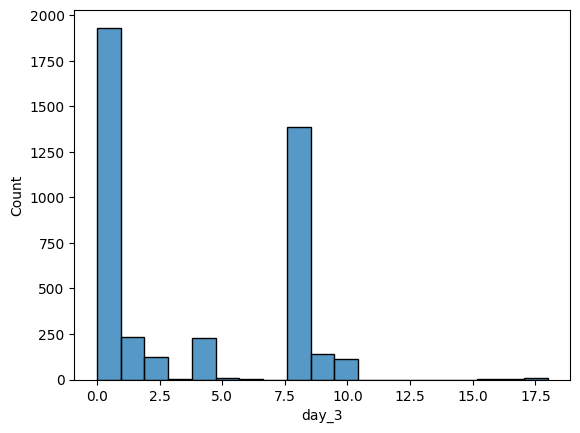

In [60]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [61]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [62]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

4179


,day_of_year,day_1,day_2,day_3
317262,181.0,1.0,8.0,1.0
314332,NaN,1.0,NaN,8.0
314014,180.0,1.0,8.0,0.0
268652,281.0,2.0,8.0,1.0
314168,NaN,1.0,NaN,4.0
314962,NaN,8.0,0.0,0.0
309967,180.0,1.0,8.0,0.0
312573,NaN,1.0,NaN,8.0
314466,180.0,1.0,8.0,0.0
312603,NaN,1.0,NaN,8.0


year - infer from day:

In [63]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_704\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_704\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963


,year,day_of_year,day_1,day_2,day_3
317267,1963.0,180.0,1.0,8.0,0.0
314061,NaN,NaN,1.0,NaN,8.0
315038,1963.0,180.0,1.0,8.0,0.0
315703,NaN,NaN,1.0,NaN,8.0
310153,1963.0,180.0,1.0,8.0,0.0
310092,1963.0,180.0,1.0,8.0,0.0
317332,1963.0,181.0,1.0,8.0,1.0
268465,NaN,NaN,2.0,8.0,NaN
315856,1963.0,181.0,1.0,8.0,1.0
314274,NaN,NaN,1.0,NaN,8.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

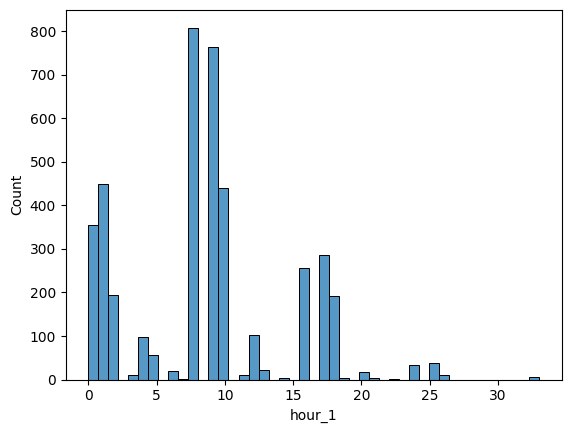

In [64]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [65]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

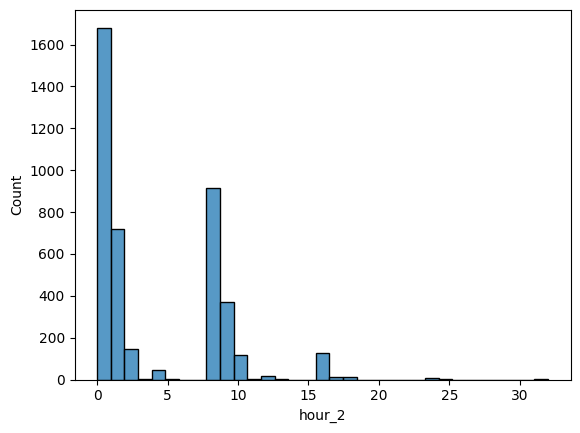

In [66]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [67]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [68]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

4179


,hour,hour_1,hour_2
319747,NaN,9.0,0.0
315136,NaN,8.0,0.0
274731,NaN,9.0,8.0
274734,NaN,NaN,0.0
308233,NaN,NaN,0.0
314090,NaN,8.0,9.0
316578,19.0,1.0,9.0
315838,NaN,8.0,0.0
308244,NaN,NaN,4.0
308971,18.0,1.0,8.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

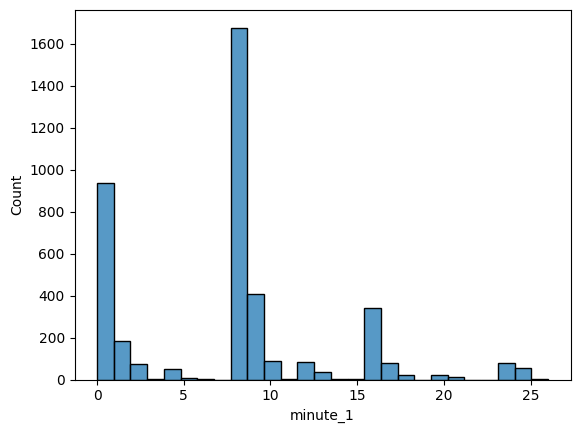

In [69]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [70]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

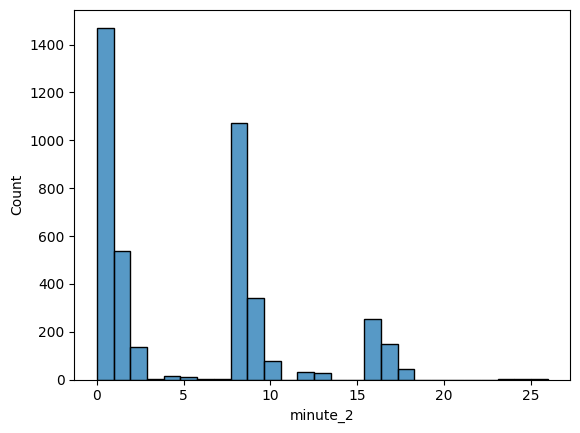

In [71]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [72]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [73]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

4179


,minute,minute_1,minute_2
274673,NaN,8.0,0.0
266201,NaN,8.0,2.0
315741,NaN,8.0,8.0
309975,NaN,2.0,NaN
317396,NaN,8.0,9.0
317441,NaN,8.0,0.0
315879,NaN,8.0,0.0
312529,8.0,0.0,8.0
310305,NaN,8.0,8.0
310466,8.0,0.0,8.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

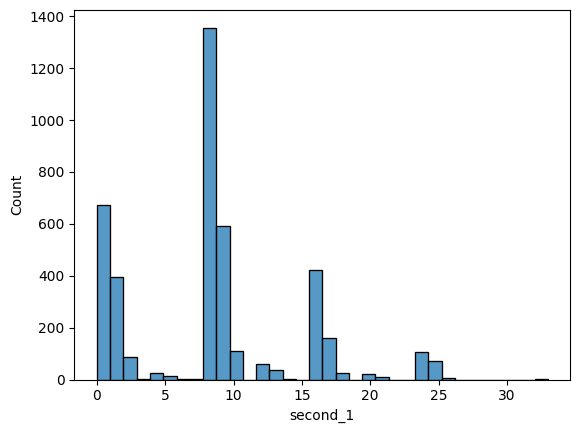

In [74]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [75]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

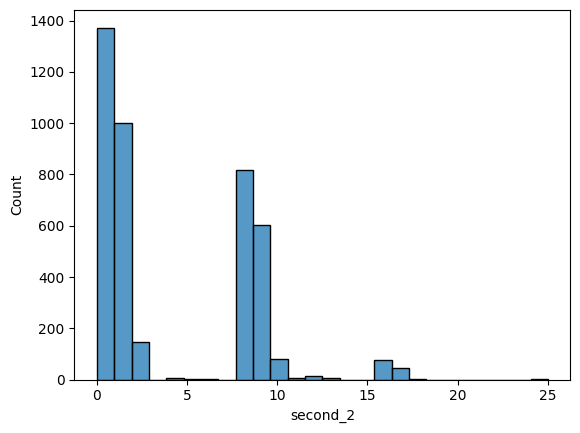

In [76]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [77]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [78]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

4179


,second,second_1,second_2
319808,NaN,NaN,1.0
315897,NaN,8.0,0.0
313928,NaN,NaN,1.0
268528,18.0,1.0,8.0
274700,NaN,8.0,0.0
314254,NaN,NaN,0.0
317874,NaN,8.0,1.0
313925,NaN,NaN,0.0
317877,19.0,1.0,9.0
309172,NaN,NaN,0.0


construct timestamp:

In [79]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

4179


In [80]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
309181,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
268454,NaN,NaN,NaN,8.0,NaN,NaN,NaT,0
315674,NaN,NaN,NaN,NaN,NaN,18.0,NaT,0
319751,1963.0,06,29,NaN,NaN,NaN,1963-06-29,4
308296,NaN,NaN,NaN,NaN,NaN,10.0,NaT,0
314091,1962.0,10,07,NaN,NaN,NaN,1962-10-07,4
274758,1962.0,10,07,0.0,NaN,NaN,1962-10-07,3
1638,NaN,NaN,NaN,0.0,2.0,0.0,NaT,0
319680,1963.0,06,29,NaN,NaN,NaN,1963-06-29,4
314159,1963.0,07,07,NaN,NaN,NaN,1963-07-07,4


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

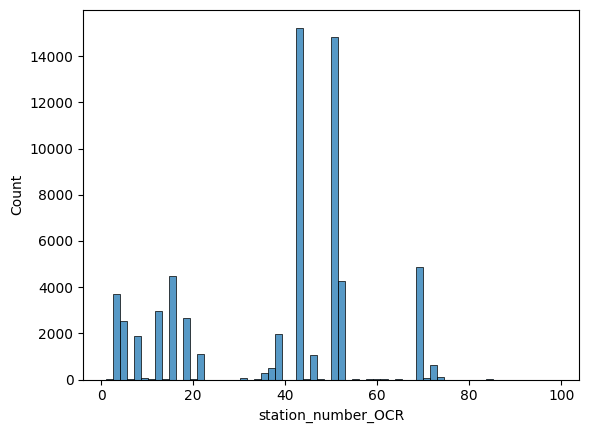

In [81]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [82]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
191733,53.0,53.0
195909,19.0,19.0
123444,69.0,69.0
199041,38.0,38.0
167005,43.0,43.0
72621,43.0,43.0
72754,43.0,43.0
60212,3.0,3.0
131822,43.0,43.0
176856,50.0,50.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

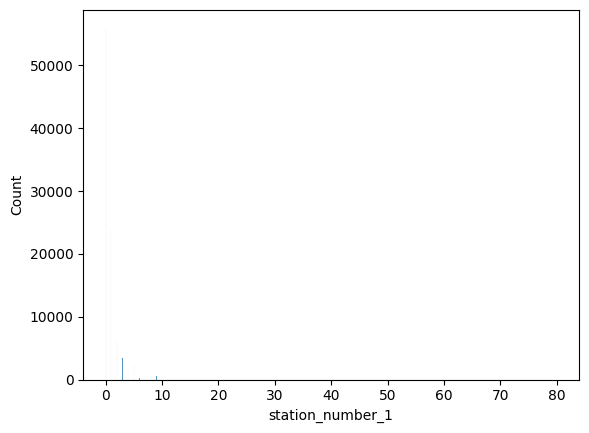

In [83]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [84]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

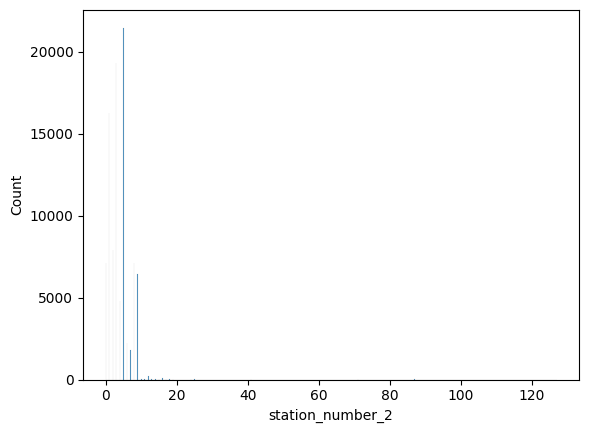

In [85]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [86]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [87]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

94928


,station_number,station_number_1,station_number_2
257318,1.0,0.0,1.0
278439,5.0,0.0,5.0
285372,1.0,0.0,1.0
287101,5.0,0.0,5.0
266981,5.0,0.0,5.0
342359,5.0,0.0,5.0
261734,3.0,0.0,3.0
287478,8.0,0.0,8.0
310946,1.0,0.0,1.0
303588,9.0,0.0,9.0


dot:

In [88]:
df_dot[['station_number']].sample(10)

,station_number
317365,8.0
266281,11.0
274645,2.0
315831,16.0
314337,8.0
309005,1.0
308298,21.0
312597,9.0
313957,32.0
317404,16.0


#  

#### Recombine results, save:

In [89]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

355314


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
137205,R014207828,4401-69,262.png,num2,1.616935,1004.000000,69.0,NaN,NaN,NaN,...,1966.0,2.0,23.0,19.0,12.0,1.0,01-02,01,02,1966-01-02 23:19:12
264665,R014207941,1799-5A,58.png,num,1.504032,1273.076923,5.0,0.0,5.0,4.0,...,1966.0,171.0,10.0,22.0,20.0,1.0,06-20,06,20,1966-06-20 10:22:20
141641,R014207828,4426-43-2,51.png,loss,1.830645,1434.693878,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
213084,R014207837,3986-50,30.png,num2,1.629032,1372.340426,50.0,NaN,NaN,NaN,...,NaN,111.0,11.0,24.0,51.0,0.0,04-21,04,21,NaT
3546,R014207807,4960,1.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
48094,R014207813,5019,68.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
23251,R014207810,5119,379.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
83501,R014207819,4787-69,140.png,loss,1.500000,1246.666667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
263659,R014207941,1796-5B,304.png,num,1.580645,1290.000000,5.0,0.0,5.0,4.0,...,1966.0,167.0,11.0,23.0,3.0,1.0,06-16,06,16,1966-06-16 11:23:03
139729,R014207828,4414-21A,43.png,loss,1.500000,1352.941176,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Save:

In [90]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [91]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [92]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [93]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [94]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
3447
1963-04-25 00:00:00
9574
1963-08-06 00:00:00
13717
1965-07-01 00:00:00
23141
After 1965-07-01 00:00:00
141636


In [95]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [96]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

141636


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
138279,5.0,1965-11-20 22:51:22,QUI,"Quito, Ecuador",0.6S,78.6W
33501,43.0,1967-10-29 20:02:32,RES,"Resolute Bay, NT, Canada",74.7N,95W
141565,NaN,1967-06-14 00:00:00,NaN,NaN,NaN,NaN
87306,5.0,1966-09-08 02:09:15,QUI,"Quito, Ecuador",0.6S,78.6W
48011,43.0,1967-04-25 14:07:28,RES,"Resolute Bay, NT, Canada",74.7N,95W
102489,5.0,1967-03-06 10:29:20,QUI,"Quito, Ecuador",0.6S,78.6W
97329,13.0,1966-12-12 08:15:24,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
114425,4.0,1967-02-24 07:49:58,NEW,"St. John's, NL, Canada",47.6N,52.4W
19576,NaN,1964-08-09 21:22:03,NaN,NaN,NaN,NaN
77101,9.0,1966-05-17 19:56:19,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W


#  

#### Save Master:

In [97]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

129532


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
71728,R014207839,4124-50A,38.png,num2,1.500000,1120.408163,1967-08-26 08:40:30,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
13407,R014207961,1038-A,111.png,dot,1.580645,1444.000000,1963-06-29 00:00:00,4.0,17.0,MOJ,"Mojave, CA, USA",35.3N,116.9W
43755,R014207831,3918-43A,219.png,num2,1.612903,1404.347826,1967-02-18 02:03:56,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
13329,R014207961,1067-A,228.png,dot,1.512097,1344.000000,1963-07-07 00:00:00,4.0,8.0,ANT,"Antofagasta, Chile",23.6S,70.3W
95682,R014207945,2254-5A,323.png,num,1.500000,1192.000000,1967-01-21 16:33:35,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
31451,R014207818,4221-69A,244.png,num2,1.500000,1184.000000,1967-10-20 18:00:12,1.0,69.0,TRO,"Tromso, Norway",69.7N,18.9E
116326,R014207961,1034-B,8.png,num,1.705645,1051.923077,1965-09-02 07:39:08,1.0,9.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
109263,R014207950,2526-5B,122.png,num,1.685484,1431.481481,1967-04-22 18:23:12,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
14825,R014207837,4027-53A,144.png,num2,1.818548,1996.969697,1965-06-20 10:02:28,1.0,53.0,KNO,"Kano, Nigeria",12N,8.5E
28296,R014207817,4182-5,126.png,num2,1.500000,1834.782609,1966-11-09 22:35:42,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W


In [98]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)